In [20]:
import json
from pathlib import Path
from GDPRDataset import GDPRDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")
from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /home/erik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



# Load config
Load config for getting stats on dev dataset

In [2]:
config_file = open(f"{str(Path.cwd())}/analysis_dev_datasets_config.json")
config = json.load(config_file)
config_file.close()

# Get language distribution

In [3]:
dev_dataset_df = GDPRDataset(config['dev_dataset_path']).dataframe
languages = set(dev_dataset_df["language"].values)
dev_dataset_df.groupby("language").count().head()

,url,content,page_source_html,content_removed,page_source_cleaned_html,page_source_removed_html,contains_GDPR
language,,,,,,,
__label__da,3,3,3,1,1,1,3
__label__de,310,310,310,138,138,138,310
__label__en,111,111,111,48,48,48,111
__label__nl,3,3,3,1,1,1,3
__label__th,1,1,1,0,0,0,1


In [17]:
len(dev_dataset_df[dev_dataset_df['contains_GDPR'] == True])

188

# Distribution of website lengths

In [4]:
refined_df = GDPRDataset(config['dev_dataset_refined_path']).dataframe
print('The refined dev dataset contains', len(refined_df), 'samples')
refined_df.head()

The refined dev dataset contains 300 samples


,language,url,content,page_source_html,content_removed,page_source_cleaned_html,page_source_removed_html,contains_GDPR
0,__label__de,https://www.mueller-ecommerce.de/,Impressum | Datenschutzerklärung,"<html><head><meta charset=""utf-8"">\n</head><bo...",None,None,None,False
1,__label__de,http://cs-media.one/,Ihre Privatsphäre ist uns wichtig Diese Web...,"<html lang=""de"" class="" js flexbox flexboxlega...",Ihre Privatsphäre ist uns wichtig Diese We...,"<html lang=""de""\n class="" js flexbox flex...","<div class=""privacypolicies-com---reset privac...",True
10,__label__de,https://www.adalis.de/,top of page Weiter zu den Hauptinha...,"<html lang=""de""><head>\n \n <meta charset=""u...",Zustimmen Einstellungen Wir verwenden C...,"<html lang=""de"">\n<head>\n\n <meta charset=...","<div class=""_2svEM _2f7c5 _4Ck7e"" data-hook=""c...",True
100,__label__de,http://www.globus-development.de/,Parkdomain Bei der aufgerufenen Domain handelt...,"<html lang=""de""><head><title>Parkdomain - GIGA...",None,None,None,False
101,__label__de,http://www.gisa.de,Email: hiltrud@cybs.io Tel: +49 (0) 9287 ...,"<html lang=""en""><head>\n <meta name=""generato...",None,None,None,False


# Get average GDPR content to total content ratio

In [5]:
# Word count ratio overall
word_ratios = []
total_len_sum = 0
gdpr_len_sum = 0
for i in range(len(refined_df)):
    if i != 97:  # exclude the one where I manually extracted a longer text, than selenium got for the total website
        word_content_len = len(word_tokenize(refined_df.iloc[i]['content']))
        total_len_sum += word_content_len
        removed_content = refined_df.iloc[i]['content_removed']
        if removed_content:
            word_gdpr_content_len = len(word_tokenize(removed_content))
        else:
            word_gdpr_content_len = 0
        gdpr_len_sum = + word_gdpr_content_len
        ratio = word_gdpr_content_len / word_content_len
        word_ratios.append(ratio)

print('overall ratio', str(gdpr_len_sum / total_len_sum))
print(np.sum(word_ratios) / len(word_ratios))
print(len(word_ratios))

overall ratio 9.506278464822449e-05
0.13154648892100967
299


overall ratio 9.79750516328522e-05
0.47693047721126464


In [6]:
# Word count ratio GDPR only
word_ratios = []
gdpr_only_df = refined_df[refined_df['contains_GDPR'] == True]
total_len_sum = 0
gdpr_len_sum = 0
for i in range(len(gdpr_only_df)):
    if i != 97:  # exclude the one where I manually extracted a longer text, than selenium got for the total website
        word_content_len = len(word_tokenize(gdpr_only_df.iloc[i]['content']))
        total_len_sum += word_content_len
        word_gdpr_content_len = len(word_tokenize(gdpr_only_df.iloc[i]['content_removed']))
        gdpr_len_sum = + word_gdpr_content_len
        ratio = word_gdpr_content_len / word_content_len
        word_ratios.append(ratio)

print('overall ratio (GDFPR only)', str(gdpr_len_sum / total_len_sum))
print(np.sum(word_ratios) / len(word_ratios))

overall ratio (GDFPR only) 0.00013069798665692374
0.2626208261716125


In [7]:
print("index:" + str(word_ratios.index(np.max(word_ratios))))
print("max:" + str(np.max(word_ratios)))
print(len(word_ratios))
word_ratios = list(filter(lambda x: x<1, word_ratios))
len(word_ratios)
np.max(word_ratios)

index:122
max:1.640081799591002
150


0.8810068649885584

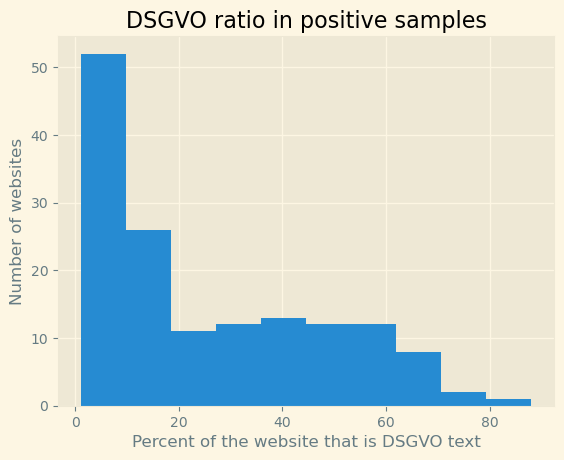

In [13]:
ratios_percent = [x*100 for x in word_ratios]
plt.style.use('Solarize_Light2')
plt.hist(ratios_percent, bins=10)
plt.title("DSGVO ratio in positive samples")
plt.xlabel("Percent of the website that is DSGVO text")
plt.ylabel("Number of websites")
plt.savefig(f"{config['save_figures_to_path']}/DSGVO_text_ratio.png")

In [4]:
# String len ratio
ratios = []
gdpr_only_df = refined_df[refined_df['contains_GDPR'] == True]
a = 0
b = 0
for i in range(len(gdpr_only_df)):
    if i != 97: # exclude the one where I manually extracted a longer text, than selenium got for the total website
        total_content_len = len(gdpr_only_df.iloc[i]['content'])
        a += total_content_len
        gdpr_content_len = len(gdpr_only_df.iloc[i]['content_removed'])
        b =+ gdpr_content_len
        ratio = gdpr_content_len / total_content_len
        ratios.append(ratio)

print('overall ratio', str(b/a))
print(np.sum(ratios)/len(ratios))

overall ratio 0.00012488973343155886
0.29372289288411324


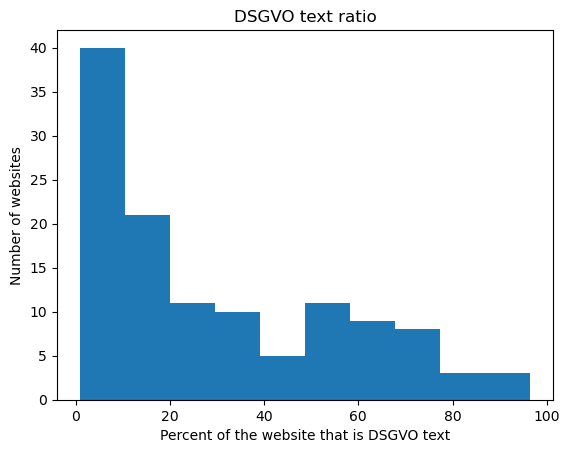

In [29]:
ratios_percent = [x*100 for x in ratios]
plt.hist(ratios_percent, bins=10)
plt.title("DSGVO text ratio")
plt.xlabel("Percent of the website that is DSGVO text")
plt.ylabel("Number of websites")
plt.savefig(f"{config['save_figures_to_path']}/DSGVO_text_ratio.png")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2f3aadb880>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2f3aadbdc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2f3aadb5e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2f3a7d8340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2f3a7d85e0>],
 'means': []}

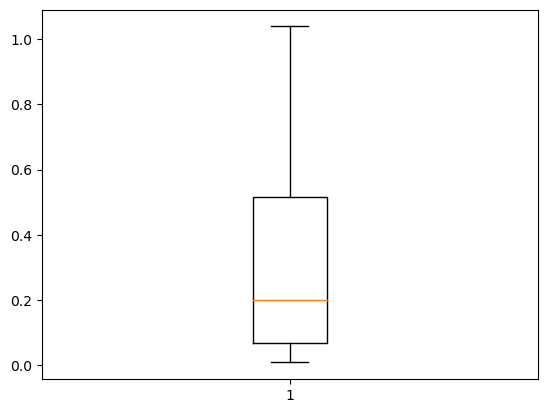

In [14]:
plt.boxplot(ratios)

# Dev Dataset simple stats

In [18]:
dev_dataset_df = GDPRDataset(config['dev_dataset_path']).dataframe
dev_dataset_ger_df = dev_dataset_df[dev_dataset_df['language'] == "__label__de"]
print("German entries in dev_dataset", len(dev_dataset_ger_df))
dev_dataset_gdpr_df = dev_dataset_df[dev_dataset_df['contains_GDPR'] == True]
print("GDPR entries in dev_dataset", len(dev_dataset_gdpr_df))
dev_dataset_ger_gdpr_df = dev_dataset_ger_df[dev_dataset_ger_df['contains_GDPR'] == True]
print("German GDPR entries in dev_dataset", len(dev_dataset_ger_gdpr_df))

German entries in dev_dataset 310
GDPR entries in dev_dataset 188
German GDPR entries in dev_dataset 138


# Dec Dataset Refined simple stats

In [5]:
dev_dataset_refined_df = GDPRDataset(config['dev_dataset_refined_path']).dataframe
print("Total entries", len(dev_dataset_refined_df))
dev_dataset_refined_gdpr_df = dev_dataset_refined_df[dev_dataset_refined_df['contains_GDPR'] == True]
print("GDPR entries in dev_dataset_refined", len(dev_dataset_refined_gdpr_df))

Total entries 300
GDPR entries in dev_dataset_refined 151


# Get common CMSs(content management system)

In [58]:
session_df = pd.DataFrame(data=dev_dataset_df)

In [76]:

html_class_names = dict()
html_ids = dict()
for i in range(0, len(session_df)):
    row = session_df.iloc[i]
    if row['contains_GDPR'] == True:
        removed_html = row['page_source_removed_html']
        soup = BeautifulSoup(removed_html, features="html.parser")
        for element in soup.find_all(name=None, recursive=True):
            element_ids = []
            element_classes = []
            if element.name in ["div"]:
                element_id = element.get('id')
                if element_id is not None: 
                    element_ids.append(element_id)

                element_class_list = element.get('class')
                if element_class_list is not None and len(element_class_list) >0:
                    for class_name in element_class_list:
                        if class_name is not None:
                            element_classes.append(class_name)
                    
            


            for element_id in set(element_ids):
                if element_id not in html_ids.keys():
                    html_ids[element_id] = 1
                else:
                    html_ids[element_id] = html_ids[element_id] + 1

            for element_class in set(element_classes):
                if element_class not in html_class_names.keys():
                    html_class_names[element_class] = 1
                else:
                    html_class_names[element_class] = html_class_names[element_class] + 1


In [77]:
html_ids = dict(sorted(html_ids.items(), key=lambda item: item[1], reverse=True))

In [75]:
def keep_row(row):
    if row['contains_GDPR'] == True:
        soup = BeautifulSoup(row['page_source_removed_html'], features="html.parser")
        for element in soup.find_all(name=None, recursive=True):
            if element.name in ["div"]:
                element_id = element.get('id')
                if element_id in ['BorlabsCookieBox', 'CybotCookiebotDialog', 'usercentrics-language-selector', 'usercentrics-button', 'cmplz-cookiebanner-container', 'onetrust-banner-sdk', 'redim-cookiehint']:
                    return False
    return True   
                
mask = session_df.apply(keep_row, axis=1)
session_df = session_df[mask]